Computation of the Pascal triangle modulo some integer called 'base'.
If the integer is 2, this is also called the Sierpinski triangle.
The triangle is put in a square: what is usually a line is now a diagonal.

Usual Pascal triangle     

    1                         
    1 1                       
    1 2 1                     
    1 3 3 1                   
    1 4 6 4 1 

Pascal triangle in a square

    1 1 1 1 1
    1 2 3 4 5
    1 3 6 10
    1 4 10
    1 5 15

Two dimensional array s[][] such that
 - s[i][0] = s[O][i] = 1 for all i >= 0
 - s[i][j] = s[i-1][j] + s[i][j-1] mod base for all i,j >= 1

In [2]:
import matplotlib.pyplot as plt
import math
import itertools
import pandas as pd
import numpy as np
from scipy.stats import poisson
from scipy.stats import chisquare
from scipy.stats import mannwhitneyu

In [3]:


BASE = 2

class PascalModulo:
    def __init__(self,base):
        self.base = base
        self.diags = [[1]]
        
    #Add a diagonal and fill it
    def _add(self):
        self.diags[0].append(1)
        i = 1
        while i <= len(self.diags) - 1:
            self.diags[i].append( (self.diags[i-1][len(self.diags[i])] + self.diags[i][len(self.diags[i]) - 1]) % self.base )
            i+=1
        self.diags.append([1])
            
    #Get element
    def get(self,i,j):
        if (i < 1 or j < 1):
            return 1
        # Compute diagonal if not computed yet
        while (len(self.diags[0]) <= i+j):
            self._add()
        return self.diags[i][j]
    
    
# sierp = PascalModulo(BASE)
# sierp.get(7,7)
# sierp.diags 

In [4]:
class Levin:
    
    def __init__(self,size=1):
        self.size = size
        self.iterator = itertools.product([False, True], repeat=self.size)
        self.block = next(self.iterator)
        self.block_index = 0
        self.sierp = PascalModulo(2)
    
    def get_next_digit(self):
#       print('block: ' + str(self.block) + ' ' + str(self.block_index))
        #check if the whole block was consumed and get a new one
        if len(self.block)  == self.block_index:
            try:
                self.block = next(self.iterator)
            except:
                self.size += 1
                self.iterator = itertools.product([False, True], repeat=self.size)
                self.block = next(self.iterator)
            self.block_index = 0
        res = 0
        for j in range(self.size):
            res += self.sierp.get(self.block_index,self.size-j-1) * self.block[j]
        self.block_index += 1
        return res%2
    
# levin = Levin()
# for i in range(10):
#     print(levin.get_next_digit(), end = '')

In [71]:
def get_occurrences(amounts,M):
    #returns frequency of occurencies for each value in the observed range
    occs = {}
    total = 0    
    for k,v in amounts.items():
        total += 1
        if v not in occs:
            occs[v] = 0
        occs[v] = occs[v] + 1
    occs[0] = int(2**M - total)
    max_o = 0
    for k,v in occs.items():
        occs[k] = v/2**M
#         occs[k] = v
        if k > max_o:
            max_o = k
    occs_array = [occs[i] if i in occs  else 0 for i in range(max_o+1)]
    return occs_array

def get_amounts_for_ns(Ns,lamb=1):
    levin = Levin()
    Ms = [int(math.ceil(math.log(N,2) - math.log(lamb,2))) for N in Ns]
    
    min_M = min(Ms)
    max_M = max(Ms)
    max_N = max(Ns)
    
    #create dictionaries to store frequencies of every N value
    amounts = {}
    occurrences = {}
    for N in Ns:
        amounts[N] = {}    
    counter = 0
    word = ''
    
    #Get digits up to max M
    while len(word) < max_M:
        counter += 1
        word = word + str(levin.get_next_digit())
    
    #process first big word
    for i in range(len(Ms)):
        M = Ms[i]
        N = Ns[i]
        for j in range(len(word) - M + 1):
            if counter < N :
                sub_word = word[j:M+j]
                if  sub_word not in amounts[N]:
                    amounts[N][sub_word] = 0
                amounts[N][sub_word] = amounts[N][sub_word] + 1
            elif N not in occurrences:
                #Ns[i] is done and not processed, process occurences and store
                occurrences[N] = get_occurrences(amounts[N],M)
    #process up to max
    while counter <= max_N:
        #get new big word
        word = word[1:]
        word = word + str(levin.get_next_digit())
        
        #process for each M
        for i in range(len(Ms)):
            M = Ms[i]
            N = Ns[i]
            if counter < N:
                sub_word = word[len(word) - M:]
                if  sub_word not in amounts[N]:
                    amounts[N][sub_word] = 0
                amounts[N][sub_word] = amounts[N][sub_word] + 1
            else:
                if N not in occurrences:
                    #N[i] is done and not processed, process occurences and store
                    occurrences[N] = get_occurrences(amounts[N],M)
        counter += 1
            
    return occurrences

In [74]:
def get_amounts_for_first(N,lamb=1):
    get_amounts_for_ns([N],lamb)

In [76]:
def analize_result(occs,l=1,plot=True):
    actual = np.array(occs)
    M = int(math.ceil(math.log(N,2)))
    x= np.arange(0,len(occs),l)
#     p = list(map(lambda x: x*2**M ,poisson.pmf(x,l)))
    p = poisson.pmf(x,1)
#     print("lambda: " + str(l) + " chisquare: " + str(chisquare(f_obs=actual, f_exp=p,ddof=1)))
    print("MWU: " + str(mannwhitneyu(actual,p)))
    if(plot):
        plt.figure(l)
        plt.plot(x, p)
        p2 = plt.bar(x, p,label="expected")
        p1 = plt.bar(x, occs, color='#d62728',label="actual")
        plt.legend(loc='best')
        plt.show()
    

In [ ]:
lamb = [i+1 for i in range(10,20)]
N = 2**20
occurrences = get_amounts_for_first(N,lamb=lamb)

MWU: MannwhitneyuResult(statistic=18.0, pvalue=0.46803733853330987)


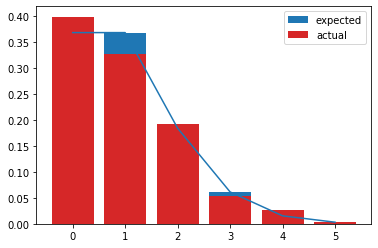

MWU: MannwhitneyuResult(statistic=23.0, pvalue=0.4491077413427273)


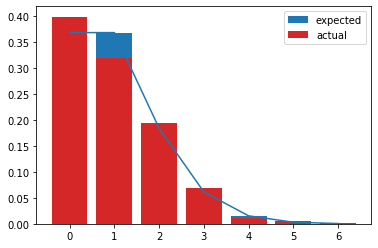

MWU: MannwhitneyuResult(statistic=36.0, pvalue=0.36189765707468813)


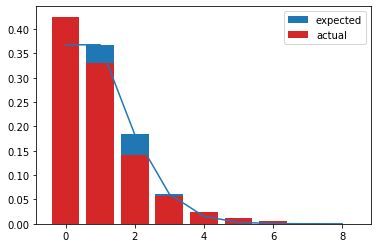

MWU: MannwhitneyuResult(statistic=41.0, pvalue=0.2601830104482655)


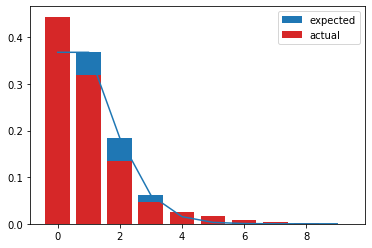

MWU: MannwhitneyuResult(statistic=62.0, pvalue=0.12953519666662766)


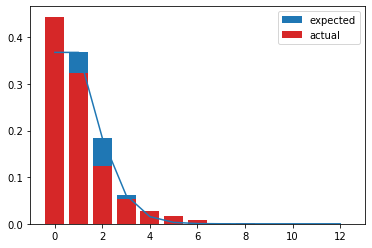

MWU: MannwhitneyuResult(statistic=94.0, pvalue=0.10330788479137654)


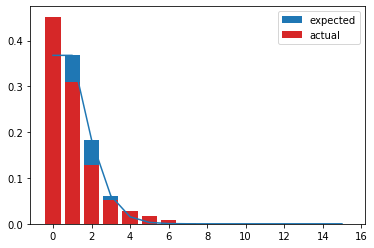

MWU: MannwhitneyuResult(statistic=111.0, pvalue=0.05501505396695189)


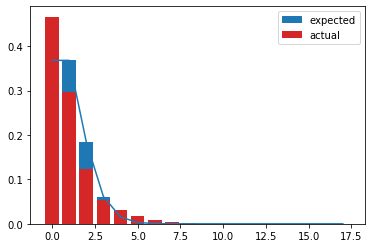

MWU: MannwhitneyuResult(statistic=111.0, pvalue=0.02196446760514372)


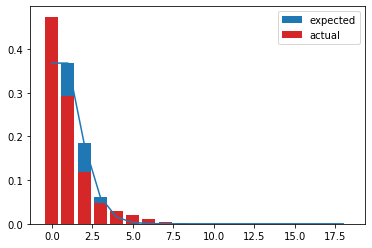

MWU: MannwhitneyuResult(statistic=127.0, pvalue=0.009650304089253232)


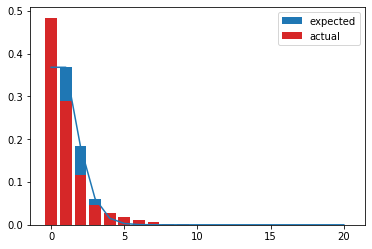

MWU: MannwhitneyuResult(statistic=133.0, pvalue=0.005434700476586038)


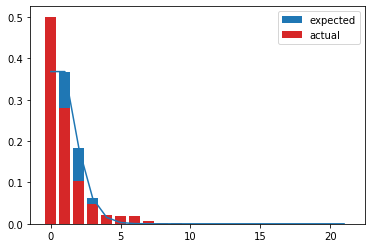

MWU: MannwhitneyuResult(statistic=197.0, pvalue=0.001931078555013984)


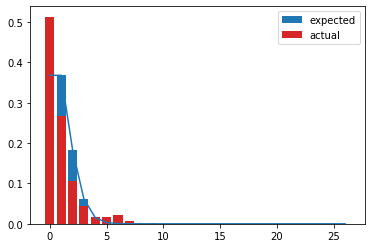

MWU: MannwhitneyuResult(statistic=243.0, pvalue=0.0011322502805564737)


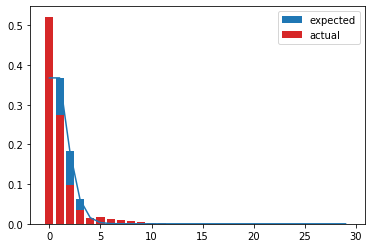

MWU: MannwhitneyuResult(statistic=218.0, pvalue=4.0578098443537e-05)


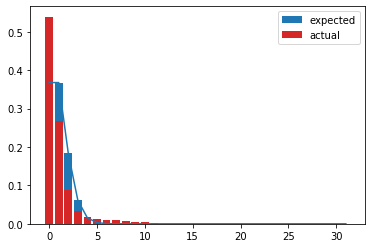

MWU: MannwhitneyuResult(statistic=243.0, pvalue=7.307187427838922e-06)


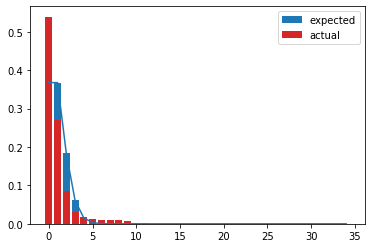

MWU: MannwhitneyuResult(statistic=304.0, pvalue=3.3312412225741657e-07)


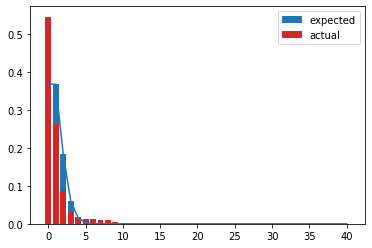

In [79]:
Ns = [2**i for i in range(10,25)]
occs = get_amounts_for_ns(Ns)

In [ ]:
for N in Ns:
    analize_result(occs[N])